In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("./Resources/cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
# I've removed the month and day as it is not necessary to include
cad_jpy_df = cad_jpy_df.loc["1990":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [4]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
#
# I've chosen to do this in a single line, as is more efficient and to
# avoid confusion there is already an explanation of what is being done.
cad_jpy_df['Return_%'] = (cad_jpy_df[["Price"]].pct_change()*100).replace(-np.inf, np.nan)
cad_jpy_df.tail()

,Price,Open,High,Low,Return_%
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
cad_jpy_df['Lagged_Return_%'] = cad_jpy_df[["Return_%"]].shift()

# Drop the NaN values created by the lag
cad_jpy_df.dropna(inplace=True)

# Confirm the data is good
cad_jpy_df.tail()

,Price,Open,High,Low,Return_%,Lagged_Return_%
Date,,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697,-0.114913
2020-06-01,79.27,78.21,79.36,78.04,1.251756,0.076697
2020-06-02,80.40,79.26,80.56,79.15,1.425508,1.251756
2020-06-03,80.70,80.40,80.82,79.96,0.373134,1.425508
2020-06-04,80.71,80.80,80.89,80.51,0.012392,0.373134


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train_df = cad_jpy_df[:'2017']
test_df = cad_jpy_df['2018':]

In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables) and ...
# X_test (test set of just the independent variables)
X_train = train_df["Lagged_Return_%"].to_frame()
X_test = test_df["Lagged_Return_%"].to_frame()

# Y_train (training set using just the "y" variable, i.e., "CAD/JPY Return") and ...
# Y_test (test set of just the "y" variable):
y_train = train_df["Return_%"]
y_test = test_df["Return_%"]

In [8]:
# Preview the X_train data
X_train.head()

,Lagged_Return_%
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901


# Linear Regression Model

In [9]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [10]:
# Make a prediction of "y" values using just the test dataset
y_prediction = model.predict(X_test)

# Have a quick squiz
y_prediction[:10]

array([ 0.00543439, -0.00731684,  0.00034045, -0.00135793, -0.01636553,
       -0.02443671,  0.00115652,  0.01734924,  0.0433532 , -0.00279188])

In [11]:
# Assemble actual y data (y_test) with predicted y data (from just above) into two columns in a dataframe:
results_df = y_test.to_frame()
results_df["Predicted_Return_%"] = y_prediction

# Have a quick squiz
results_df.sample(4)

,Return_%,Predicted_Return_%
Date,,
2018-05-24,-1.130800,0.020081
2019-01-21,-0.350242,-0.017138
2018-05-08,-0.495926,0.006406
2018-05-09,1.317195,0.011530


<AxesSubplot:title={'center':'Month 1 Predicted vs. Actual Return'}, xlabel='Date'>

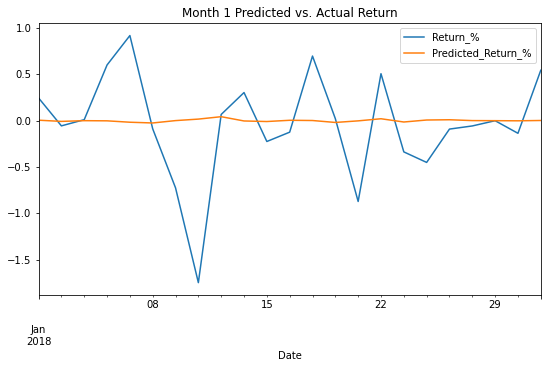

In [12]:
# Plot the first 20 predictions vs the true values
#
# I've decided to go till the end of the month (~23 days)
# One could use 'subplots=True' to perform a comparison,
# however the differences are harder to spot
results_df[:23].plot(title="Month 1 Predicted vs. Actual Return", figsize=(9,5))

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [13]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
os_mse = mean_squared_error(
    results_df["Return_%"],
    results_df["Predicted_Return_%"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
os_rmse = np.sqrt(os_mse)

# Print both
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {os_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.6445805658569028


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [14]:
# Construct a dataframe using just the "y" training data:
#is_results_df["In_sample_Return_%"] = y_train.to_frame()
is_results_df = y_train.to_frame()
is_results_df.rename(columns={"Return_%":"In_sample_Return_%"}, inplace=True)

# Add a column of "in-sample" predictions to that DataFrame:  
is_results_df["In_sample_Predicted_Return_%"] = model.predict(X_train)

# Have a squiz
is_results_df.sample(4)

,In_sample_Return_%,In_sample_Predicted_Return_%
Date,,
2009-09-22,-0.035166,0.001307
2016-10-14,0.877751,-0.004636
2015-12-30,-0.229806,-0.013990
2012-01-02,-0.052994,0.017312


In [15]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
is_mse = mean_squared_error(
    is_results_df["In_sample_Return_%"],
    is_results_df["In_sample_Predicted_Return_%"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
is_rmse = np.sqrt(is_mse)

# As before Print both
print(f"In-Sample Root Mean Squared Error (RMSE): {is_rmse}   [for MSE of: {is_mse}]")

In-Sample Root Mean Squared Error (RMSE): 0.841994632894117   [for MSE of: 0.708954961822499]


### Perform quick comparison
Before the final conclusions, I just want to perform a quick little comparison of in-sample vs. out-of-sample performance

In [23]:
# Now compare out-of-sample against in-sample mse/rmse
print("+----------------------------------------------------------------------------+")
print("|           Model Performance of In-sample vs. Out-of-sample Data            |")
print("|               +------------------------------------------------------------|")
print("|               | Root Mean Squared Error (RMSE) | Mean Squared Error (MSE)  |")
print("|               +--------------------------------+---------------------------|")
print("| Out-of-Sample | {:^30} | {:^25} |".format(os_rmse, os_mse))
print("|---------------+------------------------------------------------------------|")
print("|     In-Sample | {:^30} | {:^25} |".format(is_rmse, is_mse))
print("+----------------------------------------------------------------------------+")

+----------------------------------------------------------------------------+
|           Model Performance of In-sample vs. Out-of-sample Data            |
|               +------------------------------------------------------------|
|               | Root Mean Squared Error (RMSE) | Mean Squared Error (MSE)  |
|               +--------------------------------+---------------------------|
| Out-of-Sample |       0.6445805658569028       |     0.415484105880405     |
|---------------+------------------------------------------------------------|
|     In-Sample |       0.841994632894117        |     0.708954961822499     |
+----------------------------------------------------------------------------+


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:**  
This model is performing better with out-of-sample (the test sample) data as both RMSE and MSE are lower than those of in-sample data (the training sample).  Lower scores are an indication of higher levels of accuracy, as the deviation is lower.